In [ ]:
from io import BytesIO

import pandas as pd
import numpy as np
import numpy
import panel as pn
pn.extension('tabulator')
import matplotlib.pyplot as plt
import hvplot.pandas
import matplotlib.gridspec as gridspec
import matplotlib
import param
import scipy
from scipy.signal import find_peaks, peak_prominences
import holoviews as hv
hv.extension('bokeh')
pn.extension(comms='ipywidgets')

In [14]:
cm = 1/2.54  # centimeters in inches

## Color

In [15]:
from itertools import cycle
import random
main_colours = ['yellow', 'navajowhite', 'orange','orangered','red','darkslateblue','mediumpurple','green','yellowgreen','cyan','lightblue']
l_main_colours = cycle(main_colours)
r_main_colours = cycle(main_colours[::-1])
l_sub_colours = random.shuffle(main_colours)
r_sub_colours = random.shuffle(main_colours[::-1])

In [16]:
def get_number_of_rows(dataframe):
    df = pd.read_csv(dataframe)
    return df.shape[0]

In [17]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [18]:
@pn.cache
def fetch_data(dataframe_list):
    size = []
    data_frames = []
    minsize = None
    try:
        for data in dataframe_list:
                df = pd.read_csv(data)
                df.drop('time', axis = 1, inplace = True)
                df.insert(0,'time',df.index.values)
                df = df.fillna(0)
                size.append(df.shape[0])
                data_frames.append(df)
                minsize = min(size)
    except Exception:
        return None
    return data_frames, minsize


def cut_data(df, maxsize):
    for column in df.keys():
        upper_bound = maxsize
        df = df[df[column] < upper_bound ]
    return df

## Define widgets

In [19]:
file_input = pn.widgets.FileInput( sizing_mode='stretch_width',
                                  multiple=True)

In [20]:
def show_peaks(limbangle, ERROR = 50):
    limbangle = np.asarray(limbangle)
    peaks, _ = scipy.signal.find_peaks(x = limbangle, height = 0, prominence=(4, None))
    prominences = peak_prominences(limbangle, peaks)[0]
    contour_heights = limbangle[peaks] - prominences

    index = []
    i = 0
    for item in peaks:
        if limbangle[item] < ERROR:
            index.append(i)
        i += 1
    peaks = np.delete(peaks, index)
    contour_heights = np.delete(contour_heights,index)
    return peaks, contour_heights


In [ ]:
columns = ['shoulder','elbow','knee']
select_column = pn.widgets.Select(options=columns)
direction = ['l','r']
select_direction =  pn.widgets.Select(options=direction)

# Predict

In [22]:
import statistics
import numpy as np
import pandas as pd 
def create_features(dataframe, limbangle_raw = 'shoulderLangle'):
    df = pd.read_csv(dataframe)
    df.where(df[limbangle_raw] > 5, inplace = True)
    df.dropna(inplace = True) 
    limbangle = df[limbangle_raw].to_numpy()
    mean_limb = statistics.mean(limbangle)
    median_limb = statistics.median(limbangle)
    variance_limb = statistics.variance(limbangle)
    return_list = [mean_limb,median_limb,variance_limb]

    return return_list

def create_predict_data(dataframe , limbs = ['shoulderRangle', 'shoulderLangle','shoulderLTransv','shoulderRTransv','kneeLangle','kneeRangle','elbowLangle','elbowRangle'] ):
    index = []
    tags = ["mean", "median","variance"]
    row =  []
    df_columns = [tag + limb for limb in limbs for tag in tags ]
    for limb in limbs:
        limb_info = create_features(dataframe = dataframe, limbangle_raw = limb)
        row = row + limb_info
    return pd.DataFrame([row], columns=df_columns)


In [ ]:
import joblib
pca = joblib.load('./modelo_pca.joblib')
kmeans = joblib.load('unsupervised-jigsaw_puzzle.joblib')

##HTML Clusters


In [24]:
cluster_0 = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cluster  
 0</title>
    <link rel="stylesheet" href="style.css">
</head>
<body>
    <div class="container">
        <h1>Cluster 0</h1>
        <p>
    Cluster 0: This cluster is characterized by low median values ​​in some characteristics, 
    especially for maximum amplitude and frequency of movements. 
    High variance is observed, suggesting greater dispersion in the data. 
    This may indicate a cluster with diverse movement patterns, possibly associated with less
    predictable or more sporadic movements.
  
        </p>
    </div>
</body>
</html>
'''

In [25]:
cluster_1 = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cluster  
 0</title>
    <link rel="stylesheet" href="style.css">
</head>
<body>
    <div class="container">
        <h1>Cluster 1</h1>
        <p>
        Cluster 1: This cluster presents highest median values ​​in 
        several characteristics. The variance is moderate in most characteristics.
        This suggests a cluster representing larger and more 
        frequent movements, with prolonged duration and a consistent pattern.
  
        </p>
    </div>
</body>
</html>
'''

In [26]:
cluster_2 = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Cluster  
 0</title>
    <link rel="stylesheet" href="style.css">
</head>
<body>
    <div class="container">
        <h1>Cluster 2</h1>
        <p>

    Cluster 2: This cluster generally falls between Clusters 0 and 1 in terms of mean values. 
    It has less variation among the three clusters, indicating that the data are 
    more concentrated around the mean. Total duration and frequency of movements present great
    variations in this cluster, but still less than in the other two.
  
        </p>
    </div>
</body>
</html>
'''

In [27]:
cluster_None = '''
'''

In [28]:
import plotly.express as px
pn.extension("plotly")
import plotly.graph_objects as go


def handle_plot(data = None, limb = 'shoulder',direction = 'l', size = (10, 5)):
    n = 0
    layout_fig = go.Layout(
    xaxis_title="frequency (Hz)",  # Substitua "Tempo" pelo label desejado em x
    yaxis_title="amplitude (degrees)"  # Substitua "Ângulo do Membro" pelo label desejado em y
)
    L_curves = go.Figure(layout = layout_fig)
    R_curves = go.Figure(layout = layout_fig)

    curve = None
    if file_input.filename != None:    
        dataframes, min_size = fetch_data(file_input.filename)

        for data in dataframes:
            data = cut_data(data, min_size)
            limbLangle = scipy.signal.savgol_filter(data[limb + "L" + "angle"].to_numpy(),51,3)
            limbRangle = scipy.signal.savgol_filter(data[limb + "R" + "angle"].to_numpy(),51,3)
            time = data['time'].to_numpy()
            peaks_l, contour_l = show_peaks(limbLangle, 45)
            peaks_r, contour_r = show_peaks(limbRangle, 45)
            color_l = next(l_main_colours)
            color_r = next(r_main_colours)


            L_trace_line = go.Scatter(
                x = time,
                y = limbLangle,
                name='limb L angle ' + limb + ' ' + str(n),
                mode = 'lines',
                line=dict(color = color_l) 

            )
            L_curves.update_layout(
    width=1400,  # Adjust width as needed
    height=900   # Adjust height as needed
)
            R_curves.update_layout(
    width=1400,  # Adjust width as needed
    height=900   # Adjust height as needed
)


            L_circle = go.Scatter(
                x = peaks_l,
                y = limbLangle[peaks_l],
                name='limb L ' + limb +  'angle Peaks ' + str(n) ,
                mode = 'markers',
                marker=dict(size = 11, color = color_l) 
            )

            L_curves.add_trace(L_trace_line)
            L_curves.add_trace(L_circle)





            R_trace_line = go.Scatter(
                x = time,
                y = limbRangle,
                name = 'limb R angle ' + limb + ' ' + str(n),
                mode = 'lines',
                line=dict(color = color_r) 

            )


            R_circle = go.Scatter(
                x = peaks_r,
                y = limbRangle[peaks_r],
                name='limb R ' + limb +  'angle Peaks ' + str(n) ,
                mode = 'markers',
                marker=dict(size = 11, color = color_r) 
            )

            R_curves.add_trace(R_trace_line)
            R_curves.add_trace(R_circle)


            n = n + 1

    if direction == 'l':
        curve = L_curves
    elif direction == 'r':
        curve = R_curves

    return  curve


plotly_pane_in_place_R = pn.pane.Plotly(
    R_curves,
    height=400,
    width=700,
    # link_figure=False
)

## Define context binding widgets

In [29]:
def upload_files(files_ = None):
    if file_input.filename != None:
        file_input.save(file_input.filename)

selected = pn.bind(upload_files,file_input, watch = True)


In [30]:
selector = pn.widgets.MultiSelect(name=' ', sizing_mode='stretch_width',
options=['Add your files here'])

def update_selector(selector_widget = None, input = None):
    if file_input.filename != None:
        selector.options = file_input.filename
    else:
        selector.options =['Add your files here']
    return selector
selector_widget = pn.bind(update_selector, selector, file_input, watch = True)



In [31]:
def predict_cluster(data = None, limb = 'shoulder', direction = 'l', selector_ = None):
    
    cluster = '1000'
    if data: 
        data = data[0]
        print(data)
        predict_set = create_predict_data(dataframe="./" + data) 
        predict_set['PCA1'], predict_set['PCA2'], predict_set['PCA3'],predict_set['PCA4'], predict_set['PCA5'] = pca.transform(predict_set).T
        predict_set['cluster'] = kmeans.predict(predict_set[['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5']])
        predict_set = predict_set.drop(['meanshoulderRTransv', 'medianshoulderLTransv', 'meanshoulderRTransv', 'PCA1', 'PCA2'], axis=1) 
        limb = 'mean' + limb + direction.upper() + 'angle'
        predicted_limb = predict_set[limb][0]
        predicted_cluster = predict_set['cluster'][0]
        markdown= f'''
        {limb}: {predicted_limb}
        Cluster: {predicted_cluster}
        '''
        message = pn.pane.Markdown(markdown)
    else:
        message = ''
    return message

## Debug button

In [32]:
button = pn.widgets.Button(name='Debug', button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def b(event):
    breakpoint()
def debug(event):
    breakpoint()
button.on_click(b)


Watcher(inst=Button(button_type='primary', name='Debug'), cls=<class 'panel.widgets.button.Button'>, fn=<function b at 0x7ff5b1149790>, mode='args', onlychanged=False, parameter_names=('clicks',), what='value', queued=False, precedence=0)

## Tab 1 (sidebar & main tab 1)

In [33]:
exercises = ['e-pong','e-Invaders','e-Puzzle','e-Counter']
selected_exercises = pn.widgets.Select(options = exercises)

In [34]:
def iqr(array):
    q3, q1 = np.percentile(array,[75,25])
    IQR = q3 - q1
    upper_bound = q3 + 1.5*IQR
    lower_bound = q1 - 1.5*IQR
    return lower_bound, upper_bound

In [35]:
import plotly.express as px

def boxplot_L(data = None, limb = 'shoulder',direction = 'L', size = (400,600)):
        fig = go.Figure()

        if not not selector.value:
            data, min_size = fetch_data(selector.value)
            data = data[0]
            limbangle = limb + 'L' + "angle"
            data = data[limbangle].to_numpy()
            
            fig.add_trace(go.Box(y=data, name=limb + 'L angle'))
            
            
            fig.update_layout(
            title = limb + 'L angle ',
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            width=size[0],  # Set the width of the figure
            height=size[1], # Set the height of the figure
            boxmode='group', # Group multiple box plots if present
            boxgap=0.3,      # Adjust spacing between box plots
            boxgroupgap=0.5  # Adjust spacing between groups of box plots
        )    
            return fig
        else:    
            return None



In [36]:
def boxplot_R(data = None, limb = 'shoulder',direction = 'L', size = (400,600)):
        fig = go.Figure()

        if not not selector.value:
            data, min_size = fetch_data(selector.value)
            data = data[0]
            limbangle = limb + 'R' + "angle"
            data = data[limbangle].to_numpy()
            
            fig.add_trace(go.Box(y=data))
            
            
            fig.update_layout(
            title = limb + 'R angle ',
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            width=size[0],  # Set the width of the figure
            height=size[1], # Set the height of the figure
            boxmode='group', # Group multiple box plots if present
            boxgap=0.3,      # Adjust spacing between box plots
            boxgroupgap=0.5  # Adjust spacing between groups of box plots
        )    
            return fig
        else:    
            return None



## Tab 2

In [37]:
def plot_details(data = None, limb = 'shoulder', direction = 'l', size = (8, 4.5)):
    fig =   plt.figure(num=1, clear=True, figsize=size)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0, :])
    if not not selector.value:
        data, min_size = fetch_data(selector.value)
        [data] = data
        limbLangle = scipy.signal.savgol_filter(data[limb + "L" + "angle"].to_numpy(),51,3)
        limbRangle = scipy.signal.savgol_filter(data[limb + "R" + "angle"].to_numpy(),51,3)
        ax.plot(limbLangle,color = next(l_main_colours))
        ax.plot(limbRangle, color = next(r_main_colours))
        peaks_l, contour_l = show_peaks(limbLangle, 45)
        peaks_r, contour_r = show_peaks(limbRangle, 45) 

        ax.plot(peaks_l, limbLangle[peaks_l], "x")
        ax.vlines(x=peaks_l, ymin=contour_l, ymax=limbLangle[peaks_l])
        ax.plot(peaks_r, limbRangle[peaks_r], "x")
        ax.vlines(x=peaks_r, ymin=contour_r, ymax=limbRangle[peaks_r])
        ax.set_title(limb + "L" + "angle & "+limb +"R" + "angle") 
        ax.set(xlabel='frequency (Hz)', ylabel='amplitude (degrees)')
    return fig



In [38]:
from PIL import Image
fig_mean = Image.open('./clusters_mean.png')
clusters_mean = pn.pane.Image(fig_mean)

fig_variance = Image.open('./clusters_variance.png')
clusters_variance = pn.pane.Image(fig_variance)

In [39]:

details_widget = pn.bind(plot_details,selector, select_column, selector_widget,watch = True)
boxplot_L_widget = pn.bind(boxplot_L,selector,select_column, select_direction, watch = True)
boxplot_R_widget = pn.bind(boxplot_R,selector,select_column, select_direction, watch = True)
main_widget = pn.bind(handle_plot,file_input,select_column,select_direction, watch = True)
selected_cluster = pn.bind(predict_cluster,selector, select_column, select_direction, watch = True)

## Documentation

In [40]:
doc_markdown = ''' 

# Interface documentation: Data analysis for motor disabilities rehabilitation of upper limbs using augmented reality - ePuzzle
This interface is a data visualization tool focused on analyzing data related to upper limb motor rehabilitation with the aid of augmented reality.
 It allows the visualization of a graph that represents a patient's progress over time, possibly showing metrics such as range of motion or other variables relevant to rehabilitation.

 ## Controls

Dropdown "Choose Files": 
 Allows the selection of different patients sessions to compare their progress.
Dropdown "Selected kinect data": May allow the selection of different types of data collected by the Kinect (motion sensor), such as angles of different joints.

## Features

Progress Visualization: The main graph allows visualization of the patient's progress over time, showing how the angles of movement of the upper limbs evolve during rehabilitation.

Data Comparison: The option to select different users and data types may enable comparison of progress between patients or analysis of different aspects of movement.

# Clusters Description 

## Cluster 0 

Cluster 0 is characterized by a satisfactory range of motion in the upper limbs. This ability to move the arms and shoulders within a normal or near-normal range 
allows most daily activities to be performed without major difficulties.Preserved range of motion in the upper limbs may be indicative of good joint and muscle health, 
allowing individuals to perform daily tasks.


## Cluster 1 

Cluster 1 presents an intermediate range of motion compared to the other groups.
While it demonstrates greater restriction than Cluster 2, with its satisfactory range of motion, 
it maintains a superior movement capacity than Cluster 1, which exhibits significant limitations.
This moderate range of motion may allow the performance of many daily activities, although with 
some difficulties or adaptations in tasks that require greater flexibility or joint reach.


## Cluster 2

Cluster 2 is characterized by very limited range of motion in both the upper and lower limbs.
 This significant restriction in the ability to move joints through their full range can affect 
 the performance of daily activities such as walking, reaching, or getting dressed.'''

In [41]:
markdown = pn.pane.Markdown(doc_markdown)

## Create the Template

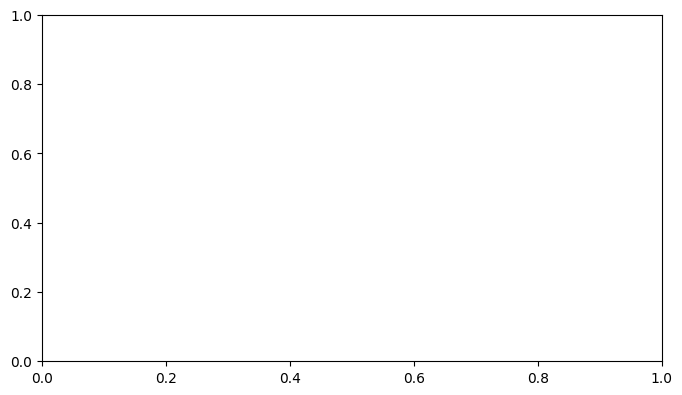

In [42]:
details_grid = pn.Column(details_widget, pn.Row(boxplot_L_widget, boxplot_R_widget, selected_cluster))

details_grid = pn.GridSpec(ncols = 2, nrows = 2)
details_grid[0, 0] = details_widget
details_grid[0, 1] = None
details_grid[1, 0] =  None
details_grid[1, 1] = selected_cluster

In [43]:
#Layout using Template
template = pn.template.BootstrapTemplate(
    title='Data analysis for motor disabilities rehabilitation of the upper limbs using augmented reality - ePuzzle', 
    sidebar=[pn.pane.Markdown(""), 
             file_input,
             select_column,
             select_direction,
             pn.pane.Markdown("### Selected Files"), 
             selector_widget,
             pn.pane.HTML(cluster_0),
             pn.pane.HTML(cluster_1),
             pn.pane.HTML(cluster_2)
            ],
    main=[ pn.Tabs(("Main",main_widget),("Details", details_grid), ("Documentation", pn.Column(markdown,clusters_mean, clusters_variance)))],
    header_background='purple',
)
template.show()
template.servable();

Launching server at http://localhost:33501
